In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score
from collections import Counter
from sklearn.metrics import classification_report

In [4]:
chunksize = 100000  # Number of rows per chunk
chunks  = pd.read_csv('/content/sample_data/SAML-D.csv', chunksize=chunksize)
df = pd.concat(chunks) # Concatenate all chunks back into a single dataframe

In [5]:
df.shape

(9504852, 12)

In [4]:
df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


In [5]:
df.columns

Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Is_laundering',
       'Laundering_type'],
      dtype='object')

In [9]:
df.Is_laundering.value_counts()

,count
Is_laundering,
0,9494979
1,9873


In [6]:
# performing some date extraction steps to break down a Date column into separate day, month, and year columns.
df['Date'] = pd.to_datetime(df['Date'])
df['day'] = df['Date'].dt.day
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

In [7]:
df['day'].unique()

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31,  1,  2,  3,  4,  5,  6],
      dtype=int32)

In [8]:
df['Laundering_type'].unique()

array(['Normal_Cash_Deposits', 'Normal_Fan_Out', 'Normal_Small_Fan_Out',
       'Normal_Fan_In', 'Normal_Group', 'Normal_Cash_Withdrawal',
       'Normal_Periodical', 'Normal_Foward', 'Normal_Mutual', 'Smurfing',
       'Normal_Plus_Mutual', 'Normal_single_large', 'Cash_Withdrawal',
       'Behavioural_Change_2', 'Structuring', 'Behavioural_Change_1',
       'Layered_Fan_In', 'Layered_Fan_Out', 'Scatter-Gather', 'Cycle',
       'Fan_In', 'Stacked Bipartite', 'Over-Invoicing', 'Deposit-Send',
       'Single_large', 'Bipartite', 'Gather-Scatter', 'Fan_Out'],
      dtype=object)

In [7]:
#  separate out the instances of interest having suspected money laundering activities
df_laundering_1 = df[df['Is_laundering'] == 1]

# selecting 30,000 rows from the subset where Is_laundering is 0.
# The random_state=42 ensures reproducibility of the sampling — every time you run this code, you'll get the same 30,000 rows.
df_laundering_0_sampled = df[df['Is_laundering'] == 0].sample(n=30000, random_state=42)

# After sampling 30,000 rows from the Is_laundering == 0 group, you create a new DataFrame df_laundering_0_remaining that contains the remaining rows.
#  The .drop() function removes the indices of the sampled rows from the original group.
df_laundering_0_remaining = df[df['Is_laundering'] == 0].drop(df_laundering_0_sampled.index)

# Concatenation creates a new df with a balanced number of 1s and 0s in the Is_laundering column, making it suitable for training machine learning models or analysis.
df = pd.concat([df_laundering_1, df_laundering_0_sampled])

In [11]:
df.shape

(39873, 15)

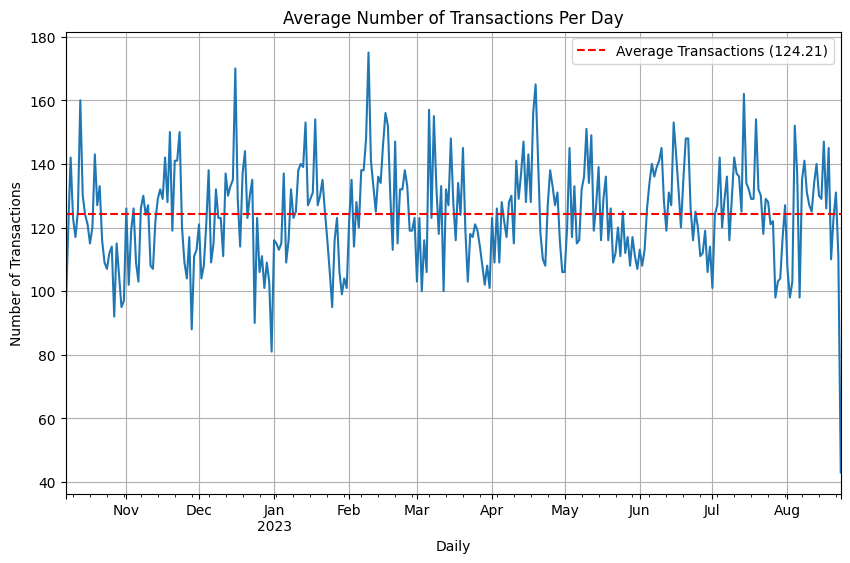

In [8]:
# calculating by grouping the transaction on a daily period and the size of each group
daily_transactions = df.groupby(df['Date'].dt.to_period('D')).size()

# here calculating the average of the daily transaction count
average_daily_transactions = daily_transactions.mean()


plt.figure(figsize=(10, 6))
daily_transactions.plot(kind='line')
plt.axhline(y=average_daily_transactions, color='r', linestyle='--', label=f'Average Transactions ({average_daily_transactions:.2f})')
plt.xlabel('Daily')
plt.ylabel('Number of Transactions')
plt.title('Average Number of Transactions Per Day')
plt.legend()
plt.grid(True)
plt.show();

In [9]:
# count how many transactions related to money laundering occurred in each month.
laundering_counts_by_month = df[df['Is_laundering'] == 1].groupby('month').size()
print(laundering_counts_by_month)

month
1      940
2      946
3      927
4      962
5      866
6     1024
7      983
8      830
10     694
11     794
12     907
dtype: int64


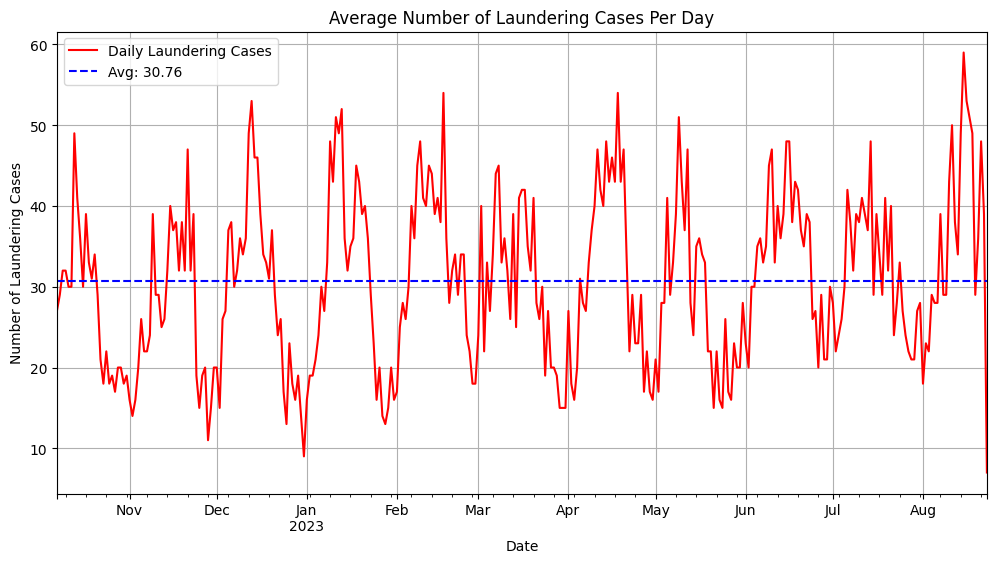

In [10]:
import matplotlib.pyplot as plt

df['Date'] = pd.to_datetime(df['Date'])

#calculating the average number of money laundering cases on a dat to day period.
daily_laundering = df[df['Is_laundering'] == 1].groupby(df['Date'].dt.to_period('D')).size()
average_laundering_per_day = daily_laundering.mean()

plt.figure(figsize=(12, 6))
daily_laundering.plot(kind='line', color='red', label='Daily Laundering Cases')

plt.axhline(average_laundering_per_day, color='blue', linestyle='dashed', label=f'Avg: {average_laundering_per_day:.2f}')

plt.xlabel('Date')
plt.ylabel('Number of Laundering Cases')
plt.title('Average Number of Laundering Cases Per Day')
plt.legend()
plt.grid(True)
plt.show()

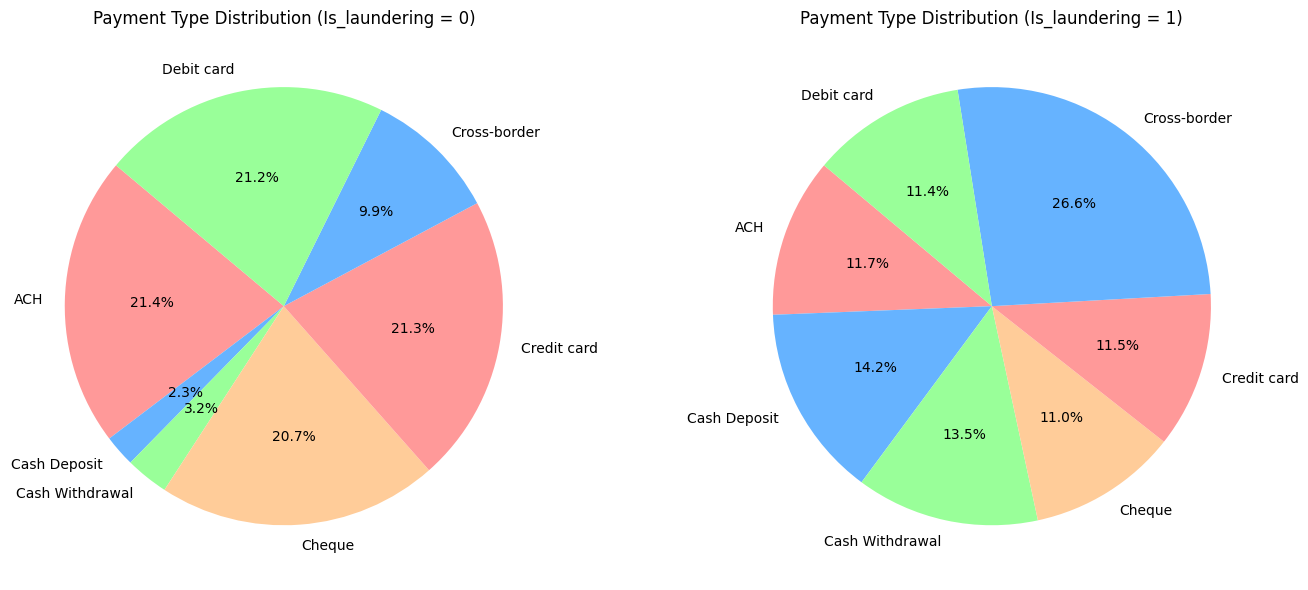

In [12]:
# create pie charts visualizing the distribution of payment types based on whether or not the transactions are classified as laundering

import matplotlib.pyplot as plt

payment_distribution = df.groupby(['Is_laundering', 'Payment_type']).size().unstack()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, laundering_status in enumerate([0, 1]):
    axes[i].pie(payment_distribution.loc[laundering_status], labels=payment_distribution.columns,
                autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
    axes[i].set_title(f'Payment Type Distribution (Is_laundering = {laundering_status})')

plt.tight_layout()
plt.show()

In [13]:
df.drop(columns=['Time', 'Date', 'Laundering_type'], inplace=True)
df

,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,day,month,year
317,7401327478,4336451277,2603.30,UK pounds,UK pounds,UK,UK,Cash Deposit,1,7,10,2022
1206,6340007440,4316483340,106.04,UK pounds,Indian rupee,UK,India,Cash Withdrawal,1,7,10,2022
1649,3758118046,6081504025,5903.33,UK pounds,Mexican Peso,UK,Mexico,Cross-border,1,7,10,2022
1954,445154846,4497771501,3957.87,UK pounds,Naira,UK,Nigeria,Cross-border,1,7,10,2022
3304,2758469152,2987279234,7832.41,UK pounds,UK pounds,UK,UK,Debit card,1,7,10,2022
...,...,...,...,...,...,...,...,...,...,...,...,...
5093120,4425879237,9912131841,11071.40,UK pounds,UK pounds,UK,UK,ACH,0,27,3,2023
4756358,944098747,7474085003,4384.44,UK pounds,UK pounds,UK,UK,Cheque,0,15,3,2023
1138120,3005535694,9719262727,14310.44,UK pounds,UK pounds,UK,UK,Cheque,0,15,11,2022
308483,3659507181,5411497315,1587.21,UK pounds,UK pounds,UK,UK,Cheque,0,17,10,2022


In [14]:
# compare 2 columns and return True if currency difer or otherwise.
df['change_currency'] = (df['Payment_currency'] != df['Received_currency']).astype(int)
df['change_location'] = (df['Sender_bank_location'] != df['Sender_bank_location']).astype(int)
df.head()

,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,day,month,year,change_currency,change_location
317,7401327478,4336451277,2603.30,UK pounds,UK pounds,UK,UK,Cash Deposit,1,7,10,2022,0,0
1206,6340007440,4316483340,106.04,UK pounds,Indian rupee,UK,India,Cash Withdrawal,1,7,10,2022,1,0
1649,3758118046,6081504025,5903.33,UK pounds,Mexican Peso,UK,Mexico,Cross-border,1,7,10,2022,1,0
1954,445154846,4497771501,3957.87,UK pounds,Naira,UK,Nigeria,Cross-border,1,7,10,2022,1,0
3304,2758469152,2987279234,7832.41,UK pounds,UK pounds,UK,UK,Debit card,1,7,10,2022,0,0


In [15]:
# dropping the columns
df.drop(columns=['Received_currency', 'Sender_bank_location', 'Payment_currency','Receiver_bank_location'], inplace=True)

# convert categorical data into numeric labels.
encoder = LabelEncoder()
df['Payment_type'] = encoder.fit_transform(df['Payment_type'])
df.head()

,Sender_account,Receiver_account,Amount,Payment_type,Is_laundering,day,month,year,change_currency,change_location
317,7401327478,4336451277,2603.30,1,1,7,10,2022,0,0
1206,6340007440,4316483340,106.04,2,1,7,10,2022,1,0
1649,3758118046,6081504025,5903.33,5,1,7,10,2022,1,0
1954,445154846,4497771501,3957.87,5,1,7,10,2022,1,0
3304,2758469152,2987279234,7832.41,6,1,7,10,2022,0,0


In [16]:
# Detecting an outlier using Isolation Forest Algoritm
from sklearn.ensemble import IsolationForest

df_selected = df.drop(columns=['Is_laundering'])
iso_forest = IsolationForest(contamination=0.1, random_state=42)

df['predicted_outlier'] = iso_forest.fit_predict(df_selected)
df['predicted_outlier'] = df['predicted_outlier'].map({-1: 1, 1: 0}) #mapping -1(outlier) to 1 and otherwise

print(df[['Is_laundering', 'predicted_outlier']].head())

      Is_laundering  predicted_outlier
317               1                  0
1206              1                  1
1649              1                  1
1954              1                  1
3304              1                  0


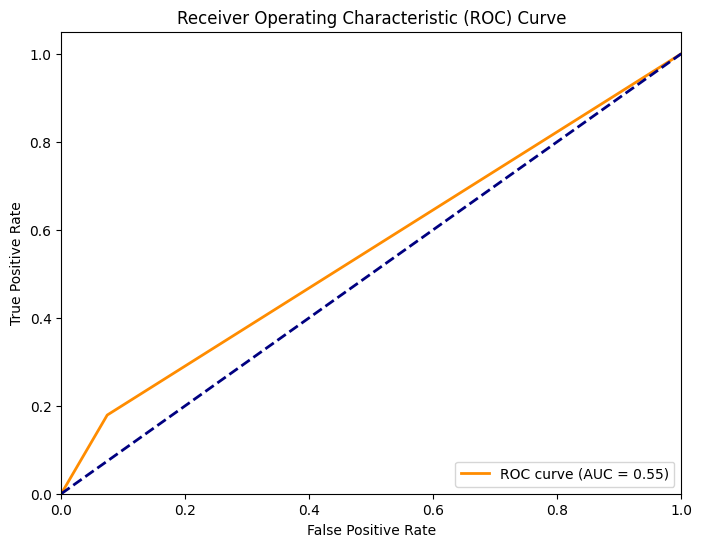

In [17]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(df['Is_laundering'], df['predicted_outlier'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [30]:
# Counter object that counts the occurrences of each label in the Is_laundering column.

most_common_label, most_common_count = Counter(df['Is_laundering']).most_common(1)[0]
nir = most_common_count / len(df['Is_laundering'])

print(f"No Information Rate (NIR): {nir:.4f}")
print(classification_report(df['Is_laundering'], df['predicted_outlier']))

print(most_common_label, most_common_count, len(df['Is_laundering'] ) )

No Information Rate (NIR): 0.7524
              precision    recall  f1-score   support

           0       0.77      0.93      0.84     30000
           1       0.44      0.18      0.25      9873

    accuracy                           0.74     39873
   macro avg       0.61      0.55      0.55     39873
weighted avg       0.69      0.74      0.70     39873

0 30000 39873


In [31]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = df_selected
y = df['Is_laundering']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [32]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"Test AUC: {roc_auc}")

Test AUC: 0.8092633272310992


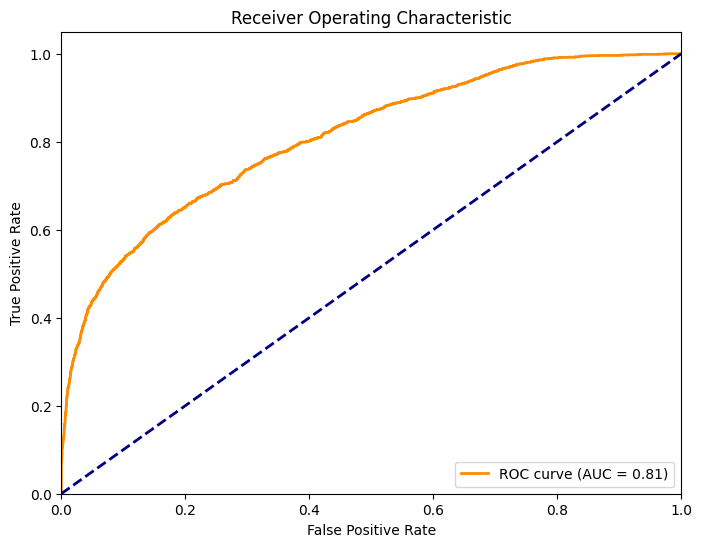

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [35]:
most_common_label, most_common_count = Counter(y_test).most_common(1)[0]
nir = most_common_count / len(y_test)

print(f"No Information Rate (NIR): {nir:.4f}")
print(classification_report(y_test, y_pred))

print(most_common_label, most_common_count, len(y_test) )

No Information Rate (NIR): 0.7456
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5946
           1       0.59      0.59      0.59      2029

    accuracy                           0.79      7975
   macro avg       0.73      0.72      0.72      7975
weighted avg       0.79      0.79      0.79      7975

0 5946 7975
